In [1]:
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import seaborn as sns

import shutil
from imageio import imread
import imageio
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from keras.callbacks import TensorBoard
import cv2
from skimage.transform import resize
import PIL

from keras.optimizers import Adam,SGD
%env SM_FRAMEWORK=tf.keras

import tensorflow as tf

from keras import backend as K
import tensorflow_addons as tfa


from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Input, Add, Dropout,Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, concatenate,Conv2DTranspose,GlobalMaxPool2D,GlobalAveragePooling2D,UpSampling2D
import gc
!pip install segmentation-models
from segmentation_models import Unet,PSPNet,FPN,Linknet


PATH            = '/content/drive/Shared drives/ACloudDrive/tianchi/s2_data/data/'
TEST_PATH       = '/content/drive/Shared drives/ACloudDrive/tianchi/s2_data/data/test/'
CKPT_PATH       = '/content/drive/Shared drives/ACloudDrive/tianchi/s2_data/data/model/'

# GPU info
! /opt/bin/nvidia-smi 

env: SM_FRAMEWORK=tf.keras
     |████████████████████████████████| 51kB 7.2MB/s 
Segmentation Models: using `tf.keras` framework.
Wed Nov 25 01:11:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------------------------------------

# Load test data

In [10]:
!ls /content/drive/Shareddrives/ACloudDrive/tianchi/s2_data/data/model

20201116-142149_efficientnetb0_model.h5
20201116-142324_densenet121_model.h5
20201116-142518_efficientnetb0_model.h5
20201116-142957_efficientnetb0_model.h5
20201116-143611_efficientnetb0_model.h5
20201116-171720_efficientnetb3_model.h5
20201116-183556_densenet201_model.h5
20201116-190553_mobilenetv2_model.h5
20201116-192620_PSPNet_efficientnetb3_model.h5
20201116-200200_PSPNet_densenet201_model.h5
20201117-021024_PSPNet_mobilenet_model.h5
20201117-022245_PSPNet_efficientnetb3_model.h5
20201117-024355_PSPNet_efficientnetb0_model.h5
20201117-034826_PSPNet_efficientnetb0_model.h5
20201117-071634_FPN_efficientnetb0_model.h5
20201117-075250_Linknet_efficientnetb0_model.h5
20201117-080552_Unet_efficientnetb0_model.h5
20201117-092356_Unet_efficientnetb0_model.h5
20201117-094843_Unet_efficientnetb3_model.h5
20201117-113640_Unet_densenet121_model.h5
20201117-114846_Unet_efficientnetb3_model.h5
20201117-122308_Linknet_efficientnetb3_model.h5
20201118-014711_Unet_efficientnetb3_model.h5
20201118

In [2]:
from sklearn.utils import shuffle
from tqdm import tqdm_notebook, _tqdm_notebook
def MakeTestData():
    df = pd.DataFrame()
    X1 = []
    for i in (list({i.split('.')[0] for i in os.listdir(TEST_PATH)})):
        i = i.split('.')[0]
        X1.append(TEST_PATH + '{}.jpg'.format(i))
    df['X1']  =  X1
    return df
test_df = pd.DataFrame()
test_df = MakeTestData()
print(test_df.shape)

X_test = []
for filename in tqdm_notebook(test_df['X1'].values, position=0, leave=True):
    temp = Image.open(filename)
    w,h = temp.size
    temp = resize(imread(filename),(512, 512, 3))
    temp = np.array(temp)
    X_test.append(temp)
gc.collect()
X_test = np.array(X_test)

# from numpy import save,load
# save(PATH+'npy/X_test.npy', X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  


(1500, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


# Load model

In [11]:
from keras.models import load_model

model_name = Unet
backbone_name = 'densenet201'
weight = '20201125-082916_Unet_densenet201_model.h5'
model = Unet(backbone_name, classes=1, activation='sigmoid')

model_path = "/content/drive/Shareddrives/ACloudDrive/tianchi/s2_data/data/model/" + weight
model.load_weights(model_path)

# model summary
#print(model.summary(line_length=120))

# Predict

In [12]:
predicted_test = model.predict(X_test)

## Plot: test demo 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


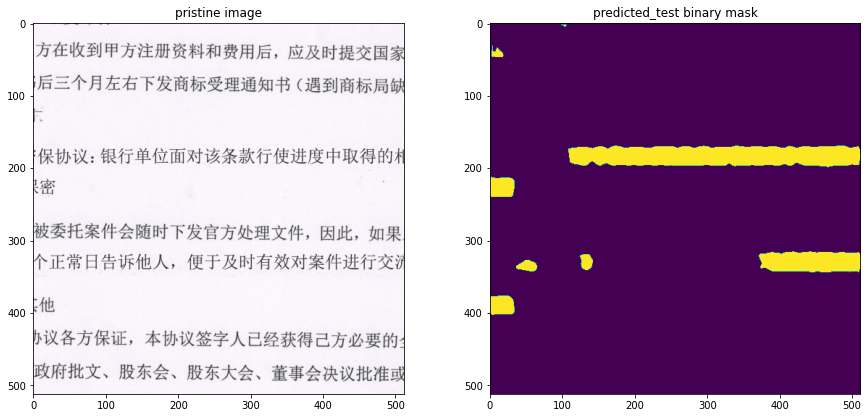

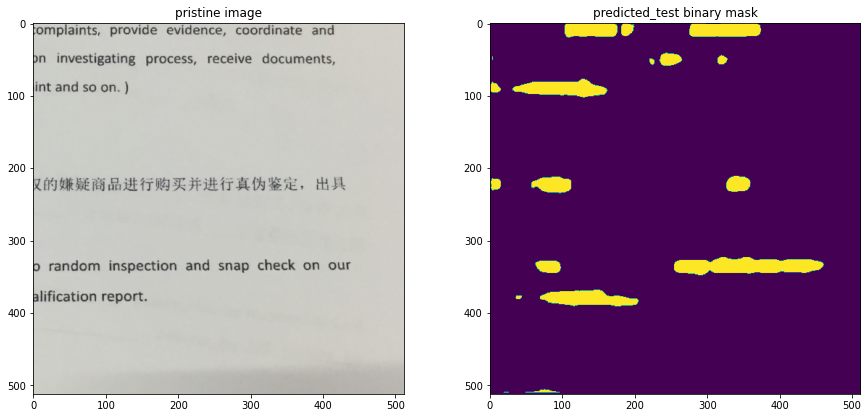

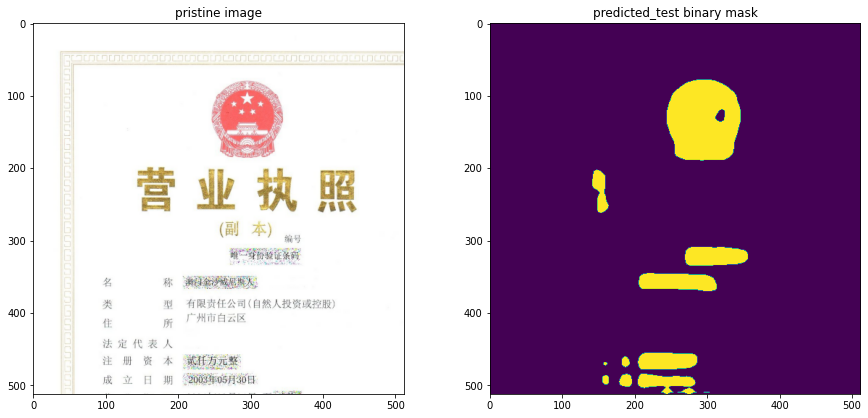

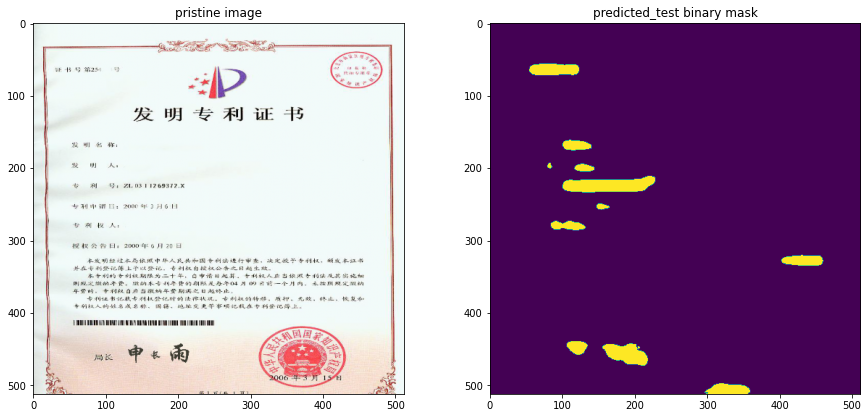

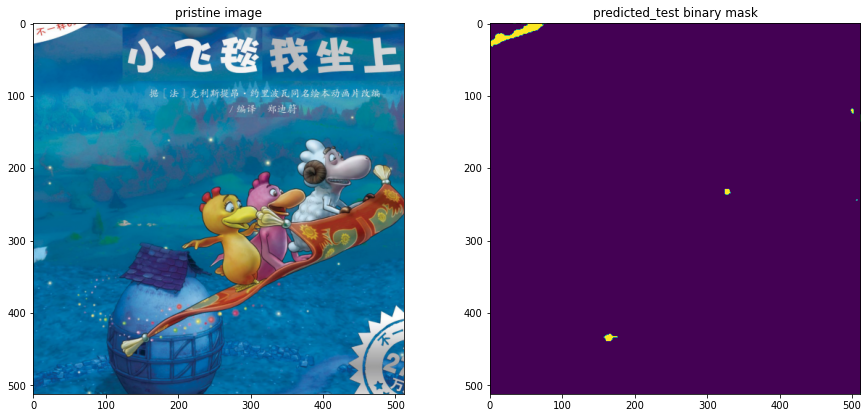

In [13]:
TEST_MASK_PATH = PATH + 'images/'
from PIL import Image 
def plot_predicted_test(index):
    each_test_name = []
    each_test_path = []
    for i in (list({i.split('.')[0] for i in os.listdir(TEST_PATH)})):
        i = i.split('.')[0]
        each_test_path.append(TEST_PATH + '{}.jpg'.format(i))
        each_test_name.append(i) #number

    pred = np.squeeze(predicted_test[index])
    plt.imsave('pred_mask.png',pred)
    im_gray = cv2.imread('pred_mask.png', cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(im_gray, 220, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)   
    ax1.set_title("pristine image")
    ax2.set_title("predicted_test binary mask")

    ax1.imshow(X_test[index])
    ax2.imshow(im_bw)

from tqdm import tqdm_notebook, _tqdm_notebook
import random
for i in tqdm_notebook(range(0,5)):
    x = random.randint(1,1500)
    plot_predicted_test(x)

## Save: resize and save

In [14]:
TEST_MASK_PATH = PATH + 'images/'
from PIL import Image 
import random
from tqdm import tqdm_notebook, _tqdm_notebook


# Save mask
print('Get img name and path')
each_test_name = []
each_test_path = []

for i in tqdm.notebook.tqdm(list({i.split('.')[0] for i in os.listdir(TEST_PATH)})):
    i = i.split('.')[0]
    each_test_path.append(TEST_PATH + '{}.jpg'.format(i))
    each_test_name.append(i) 


# Resize mask
print('Get img height and width')
h = []
w = []
for filename in tqdm.notebook.tqdm(each_test_path):
    temp = Image.open(filename)
    h.append(temp.height)
    w.append(temp.width)

print('Resize and save img')
for index in tqdm.notebook.tqdm(range(0,1500)):
    pred = np.squeeze(predicted_test[index])
    plt.imsave('pred_mask.png',pred)
    im_gray = cv2.imread('pred_mask.png', cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(im_gray, 220, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    im_bw_t = Image.fromarray(im_bw) 
    im_bw_t.save(TEST_MASK_PATH+'{}.png'.format(each_test_name[index]))
        
    im_bw_t_n = Image.open(TEST_MASK_PATH+'{}.png'.format(each_test_name[index]))
    im_bw_t_nn = im_bw_t_n.resize(( w[index], h[index]),Image.ANTIALIAS)
    im_bw_t_nn.save(TEST_MASK_PATH+'{}.png'.format(each_test_name[index]))
print('DONE! Save mask img！')

Get img name and path



Get img height and width



Resize and save img



DONE! Save mask img！


In [15]:
len(os.listdir(TEST_MASK_PATH))

1500

In [16]:
!zip -qj0 images.zip /content/drive/Shared\ drives/ACloudDrive/tianchi/s2_data/data/images/*.png